2018 Oct 9<br>
Since I'm getting a little short on time for DPS, I'm going to do a quick once-through of the planned full analysis using the Levenberg-Marquardt approach, with simplified error estimates. Later, I'll go back through with the MCMC analysis to clean up uncertainty estimates.

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit

from lightkurve import KeplerLightCurveFile
from PyAstronomy.modelSuite.XTran.forTrans import MandelAgolLC

from transit_utils import bindata, transit_duration, supersample_time
from variable_eclipses_utils import *

from BEER_curve import BEER_curve

K76 = Kepler76_params()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_period = 1
binsize = 30./60./24.
    
# Retrieve while masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=num_period, 
                                                         KIC=K76.KIC, fit_bottom=True, params=K76.saved_ep, 
                                                         drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

# Estimate scatter
ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)
unbinned_noise = mad(filtered_flux[ind])
print(unbinned_noise*1e6)

141.83679022846897


In [26]:
def fit_BEER_signals(cur_time, baseline, Aellip, Abeam, Aplanet, phase_shift):
    params = K76.saved_params.copy()

    params['baseline'] = baseline
    params['Aellip'] = Aellip
    params['Abeam'] = Abeam
    params['Aplanet'] = Aplanet
    params['phase_shift'] = phase_shift

    cur_BC = BEER_curve(cur_time, params,
            supersample_factor=10, exp_time=30./60./24.)
    
    return cur_BC.all_signals()

def fit_transit(time, baseline, a, T0, p, b, supersample_factor=10, exp_time=30./60./24.):
    params = K76.saved_params.copy()

    time_supersample = supersample_time(time, supersample_factor, exp_time)
    
    ma = MandelAgolLC(orbit="circular", ld="quad")
    ma['per'] = params['per']
    ma['a'] = a
    ma['T0'] = T0
    ma['p'] = p
    ma['i'] = np.arccos(b/a)*180./np.pi
    ma["linLimb"] = params["linLimb"]
    ma["quadLimb"] = params["quadLimb"]
    
    transit_supersample = ma.evaluate(time_supersample) - 1. + baseline
    return np.mean(transit_supersample.reshape(-1, supersample_factor), axis=1)

[ 2.81406696e-05  1.30099611e-05  5.48450688e-06  4.73176998e-05
 -1.52278158e-02]
[7.29596464e-07 1.12511986e-06 9.18915799e-07 1.10022355e-06
 2.79756907e-10]
(-1.9315925643068677e-06, 0.00013777918955235323)


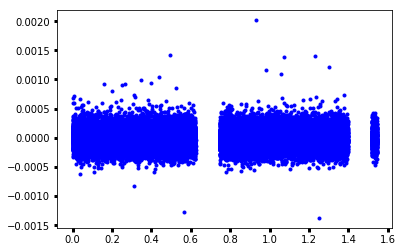

In [29]:
bounds = ([-500e-6, -500e-6, -500e-6, 0., -1],
          [500e-6, 500e-6, 500e-6, 500e-6, 1])

# Estimate scatter
out_of_transit_ind = ~(transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0']) | 
                       transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'] + 0.5*K76.saved_params['per']))
unbinned_noise = mad(filtered_flux[out_of_transit_ind])

time = folded_time[out_of_transit_ind]
data = filtered_flux[out_of_transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['Aellip'], K76.saved_params['Abeam'], K76.saved_params['Aplanet'], 
                 K76.saved_params['phase_shift']]
popt, pcov = curve_fit(fit_BEER_signals, time, data, p0=initial_guess, bounds=bounds)
uncertainties = np.sqrt(pcov.diagonal())

print(popt)
print(uncertainties)

resid = data - fit_BEER_signals(time, *popt)
print(np.median(resid), mad(resid))

plt.plot(time, resid, 'b.')
# plt.plot(binned_time, binned_data, 'b.')
# plt.plot(time, fit_all_signals(time, *popt), 'r.')
#plt.ylim([-100e-6, 100e-6])

flux_no_BEER = filtered_flux - fit_BEER_signals(folded_time, *popt)

[-9.10619601e-06  5.08603083e+00  6.84990677e-01  8.49042443e-02
  9.08706091e-01]
[4.32081165e-06 4.69095737e-02 2.24455312e-05 4.70921265e-04
 2.47421147e-03]


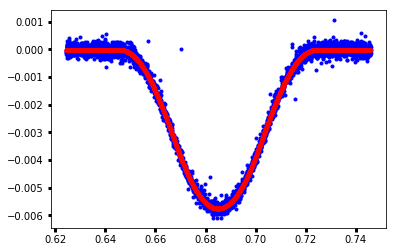

In [30]:
bounds = ([-1000e-6, 2., K76.saved_params['T0']*0.95, 0., -1],
          [1000e-6, 10., K76.saved_params['T0']*1.05, 0.2, 1])

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = flux_no_BEER[transit_ind]
err = unbinned_noise*np.ones_like(time)

initial_guess = [0., K76.saved_params['a'], K76.saved_params['T0'], K76.saved_params['p'], K76.saved_params['b']]
popt, pcov = curve_fit(fit_transit, time, data, p0=initial_guess, bounds=bounds)
uncertainties = np.sqrt(pcov.diagonal())

print(popt)
print(uncertainties)

plt.plot(time, data, 'b.')
plt.plot(time, fit_transit(time, *popt), 'r.')

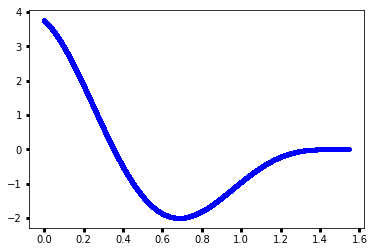

In [56]:
# Update transit ephemeris